In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution
print(tf.__version__)

1.14.0


In [2]:
twitter_data = pd.read_json('tweets_GOOG18-19_mod.json', orient='split')
stock_data = pd.read_json('GOOGL-18-19.json')

Index(['dates', 'vader_mean', 'vader_std', 'volume', 'mean_exist',
       'std_exist'],
      dtype='object')
380
Index(['APO', 'Aroon Down', 'Real Middle Band', 'MIDPOINT', 'OBV', 'SINE',
       'QUADRATURE', 'open', 'close', 'nopen', 'nhigh', 'nlow', 'nclose',
       'nvolume'],
      dtype='object')
380


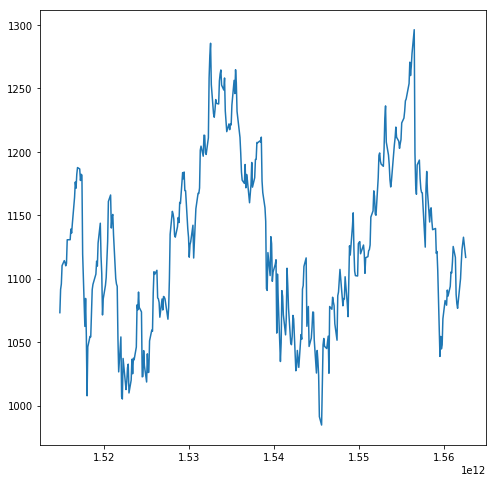

In [3]:
if(len(twitter_data) != len(stock_data)):
    twitter_data = twitter_data[:-(len(twitter_data) - len(stock_data))]

import datetime
print(twitter_data.columns)
print(len(twitter_data))
print(stock_data.columns)
print(len(stock_data))
twitter_dataMod = twitter_data

twitter_dates = list(twitter_data.get('dates'))
stock_dates = list(stock_data.index)

stock_date = [k.ctime() for k in stock_dates]
stock_nptime = np.array([np.datetime64(k, 'D') for k in stock_dates])

minTime = '2018-01-01'
maxTime = '2019-07-08'

dates = np.arange(np.datetime64(minTime), np.datetime64(maxTime))
dates = dates[np.is_busday(dates)]
datesIncluded = len(dates)

#print([k for k in dates if k not in stock_nptime])
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod.get('dates'), stock_data.get('close'))

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)

# Shift the data to enable one-step t + 1 prediction

# Build the x and y values, note: x includes the previous opening price and closing prices

LAG_STEPS = 3 # Counted including implied lag step of 1

dataLength = len(twitter_dataMod)-1

#twitter_dataMod2 = twitter_dataMod.drop(twitter_dataMod.index[[np.array(range(LAG_STEPS)), 
#                                                               dataLength-np.array(range(LAG_STEPS))]])
#stock_dataMod = stock_data.drop(stock_data.index[[np.array(range(LAG_STEPS)), 
#                                                               dataLength-np.array(range(LAG_STEPS))]])
#stock_dataMod2 = stock_data.drop(stock_data.index[np.array(range(LAG_STEPS*2))])
twitter_dataMod2 = twitter_dataMod.to_numpy()
scaler.fit(twitter_dataMod2[:,3].reshape(-1, 1))
twitter_dataMod2[:,3] = np.ravel(scaler.transform(twitter_dataMod2[:,3].reshape(-1,1)))
twitter_dataMod2 = np.delete(twitter_dataMod2, 0, axis = 1)

stock_dataMod = stock_data.to_numpy()
scaler.fit(stock_dataMod)
stock_dataMod = scaler.transform(stock_dataMod)
stock_dataMod = np.delete(stock_dataMod, [7,8], axis = 1)

stock_dataMod2 = stock_data.to_numpy()
scaler.fit(stock_dataMod2)
stock_dataMod2 = scaler.transform(stock_dataMod2)
stock_dataMod2 = np.delete(stock_dataMod2, [0,1,2,3,4,5,6,9,10,11,12,13], axis = 1)


for i in range(LAG_STEPS, dataLength):
    temp_twitter = (twitter_dataMod2[i - np.array(range(LAG_STEPS))]).reshape(1,-1)
    temp_stock = (stock_dataMod[i - np.array(range(LAG_STEPS))]).reshape(1,-1)
    temp_stock2 = (stock_dataMod[i - np.array(range(1, 1+LAG_STEPS))]).reshape(1,-1)
    if i == LAG_STEPS:
        x_unscaled = np.concatenate((temp_twitter, temp_stock, temp_stock2), axis = 1)
    else:
        temp_arr = np.concatenate((temp_twitter, temp_stock, temp_stock2), axis = 1)
        x_unscaled = np.concatenate((x_unscaled, temp_arr), axis = 0)

print(len(x_unscaled))
print(x_unscaled[0])
print(len(x_unscaled[0]))

stock_dataMod3 = stock_data.drop(stock_data.index[range(LAG_STEPS)]).to_numpy()

y_open = stock_dataMod3[:, 7]
y_close = stock_dataMod3[:, 8]
y_classifier = np.empty(y_open.size-1, dtype = int)

for i in range(y_open.size-1):
    y_classifier[i] = 1 * (y_open[i+1] >= y_open[i])

y_open = np.delete(y_open, 0)
y_close = np.delete(y_close, 0)

y_open = y_open.reshape(-1, 1)
y_close = y_close.reshape(-1, 1)
y_classifier = y_classifier.reshape(-1, 1)

print(y_open.size)
print(y_classifier.size)

376
[ 0.24772976  0.44472734  1.00333291  1.          1.          0.22167922
  0.46288545 -0.58753563  1.          1.          0.24183636  0.52487813
 -0.58753563  1.          1.          0.59868679 -0.80761959 -1.73215525
 -1.8749049   0.19815238 -1.49561189  0.22364401 -1.01860627 -1.10187236
 -0.87702868 -0.93654293 -0.4990864   0.55571191 -0.76105153 -1.77128049
 -1.97683748  0.02300521 -1.60559274  0.09542587 -1.06038989 -1.20765621
 -0.94008225 -1.09031179 -0.30161482  0.50193992 -0.71448067 -1.80619823
 -2.06246085 -0.12820524 -1.56407259 -0.13212262 -1.25102765 -1.28631601
 -1.0788001  -1.12158682 -0.12971655  0.55571191 -0.76105153 -1.77128049
 -1.97683748  0.02300521 -1.60559274  0.09542587 -1.06038989 -1.20765621
 -0.94008225 -1.09031179 -0.30161482  0.50193992 -0.71448067 -1.80619823
 -2.06246085 -0.12820524 -1.56407259 -0.13212262 -1.25102765 -1.28631601
 -1.0788001  -1.12158682 -0.12971655  0.45600663 -1.27331975 -1.84051748
 -2.1655737  -0.3100614  -1.53459646 -0.3575205

In [5]:
# split the data

def splitData(x, y, val):
    if not(val):
        x_train = x[range(int(0.8*len(x)))]
        y_train = y[range(int(0.8*len(x)))]
        x_test = x[range(int(0.8*len(x)), len(x))]
        y_test = y[range(int(0.8*len(x)), len(x))]
        scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
        return x, x_train, x_test, y_train, y_test
    else:
        x_temp = np.array_split(x[range(int(0.8*len(x)))], 15)
        y_temp = np.array_split(y[range(int(0.8*len(x)))], 15)
        
        x_train = np.array([arr[range(len(arr)-3)] for arr in x_temp])
        x_val = np.array([arr[range(len(arr)-3, len(arr))] for arr in x_temp])
        y_train = np.array([arr[range(len(arr)-3)] for arr in y_temp])
        y_val = np.array([arr[range(len(arr)-3, len(arr))] for arr in y_temp])
        
        x_train = x_train.reshape(-1, len(x[0]))
        x_val = x_val.reshape(-1, len(x[0]))
        y_train = y_train.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        
        x_test = x[range(1+int(0.8*len(x)), len(x))]
        y_test = y[range(1+int(0.8*len(x)), len(x))]

        return x, x_train, x_val, x_test, y_train, y_val, y_test

In [15]:
# AdaBoost regressor NuSVR
# Conduct grid search for parameters

x, x_train, x_test, y_train, y_test = splitData(x_unscaled, y_close, False)
x_val = x_train[range(int(0.8*len(x_train)), len(x_train))]
x_train = x_train[range(int(0.8*len(x_train)))]
y_val = y_train[range(int(0.8*len(y_train)), len(y_train))]
y_train = y_train[range(int(0.8*len(y_train)))]

arr = np.empty((192, 5))
counter = 0

for n_est in [25, 50, 75, 100]:
    print(n_est)
    for c_val in [10, 100, 1000, 10000]:
        for gamma_val in [0.00001, 0.0001, 0.001, 0.01]:
            for nu_val in [0.25, 0.5, 0.75]:
                reg = AdaBoostRegressor(NuSVR(nu = nu_val, kernel='rbf', max_iter=-1, gamma= gamma_val, C = c_val), 
                                        n_estimators = n_est)
                reg.fit(x_train, np.ravel(y_train))
                preds = reg.predict(x_val)
                mean = np.mean([explained_variance_score(y_val, preds), r2_score(y_val, preds)])
                arr[counter,:] = np.array([n_est, c_val, gamma_val, nu_val, mean])
                counter = counter+1

idx = np.where(arr[:,4] == np.max(arr[:,4]))
print('done')

25
50
75
100
done


[[7.50000000e+01 1.00000000e+03 1.00000000e-03 2.50000000e-01
  6.25937951e-01]]
0.8823534994494864
0.4896685773215993
508.43676463373396
1957.1072957978365
0.8823536880171468
0.6203945884217122


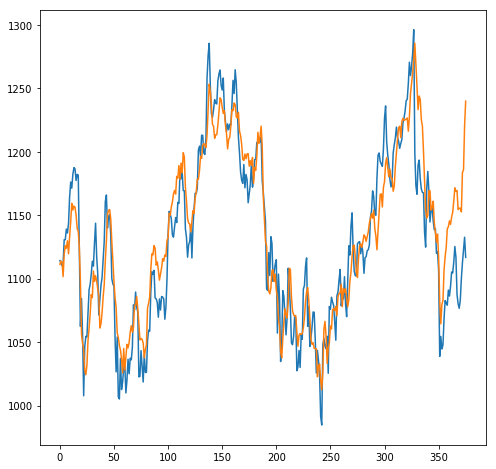

In [16]:
# Run regressor on final grid search results
x, x_train, x_test, y_train, y_test = splitData(x_unscaled, y_close, False)

print(arr[idx])
reg = AdaBoostRegressor(NuSVR(nu = arr[idx,3][0][0], kernel='rbf', max_iter=-1, gamma= arr[idx,2][0][0], C = arr[idx,1][0][0]),
    n_estimators = int(arr[idx,0][0][0]))
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
print(mean_squared_error(y_train, reg.predict(x_train)))
print(mean_squared_error(y_test, reg.predict(x_test)))
print(explained_variance_score(y_train, reg.predict(x_train), multioutput='variance_weighted'))
print(explained_variance_score(y_test, reg.predict(x_test), multioutput='variance_weighted'))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x)), reg.predict(x))

In [11]:
# LSTM Neural Net

# Split the data into train, validation, and test sets
x, x_train, x_val, x_test, y_train, y_val, y_test = splitData(x_unscaled, y_close, True)
x_train = np.expand_dims(x_train, axis = 2)
x_val = np.expand_dims(x_val, axis = 2)
x_test = np.expand_dims(x_test, axis = 2)
x = np.expand_dims(x, axis = 2)


# Try an LSTM neural network with pooling
model = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(input_shape=(87, 1), stddev = 0.5),
    tf.keras.layers.LSTM(units=75, return_sequences=False, dropout=0.25, recurrent_dropout=0.25),
    tf.keras.layers.Dense(units=1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size = 64, verbose = 2,
                    validation_data = (x_val, y_val), epochs = 5000)
print('Finished training')

# Plot training and validation loss as a function of time
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

# Print a series of metrics for training, validation, and testing data
print(mean_squared_error(y_train, model.predict(x_train)))
print(mean_squared_error(y_val, model.predict(x_val)))
print(mean_squared_error(y_test, model.predict(x_test)))
print(r2_score(y_train, model.predict(x_train)))
print(r2_score(y_val, model.predict(x_val)))
print(r2_score(y_test, model.predict(x_test)))
print(explained_variance(y_train, model.predict(x_train)))
print(explained_variance(y_val, model.predict(x_val)))
print(explained_variance(y_test, model.predict(x_test)))

# Plot the actual and predicted values
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x)), model.predict(x))

Train on 255 samples, validate on 45 samples
Epoch 1/5000
255/255 - 2s - loss: 1264339.5765 - val_loss: 1253886.0000
Epoch 2/5000
255/255 - 1s - loss: 1264146.0265 - val_loss: 1253635.8750
Epoch 3/5000
255/255 - 0s - loss: 1263738.8760 - val_loss: 1253104.0000
Epoch 4/5000
255/255 - 0s - loss: 1262949.9059 - val_loss: 1251065.1250
Epoch 5/5000
255/255 - 1s - loss: 1260089.4544 - val_loss: 1246132.6250
Epoch 6/5000
255/255 - 1s - loss: 1256384.0201 - val_loss: 1241854.0000
Epoch 7/5000
255/255 - 1s - loss: 1252555.6328 - val_loss: 1239474.5000
Epoch 8/5000
255/255 - 1s - loss: 1249416.0961 - val_loss: 1237098.0000
Epoch 9/5000
255/255 - 1s - loss: 1246421.8304 - val_loss: 1234158.2500
Epoch 10/5000
255/255 - 1s - loss: 1243283.2799 - val_loss: 1230979.2500
Epoch 11/5000
255/255 - 0s - loss: 1240596.1706 - val_loss: 1228579.7500
Epoch 12/5000
255/255 - 1s - loss: 1238417.1951 - val_loss: 1226983.1250
Epoch 13/5000
255/255 - 1s - loss: 1236831.3931 - val_loss: 1225665.7500
Epoch 14/5000
2

Epoch 113/5000
255/255 - 1s - loss: 1163067.2819 - val_loss: 1152785.3750
Epoch 114/5000
255/255 - 0s - loss: 1162415.1882 - val_loss: 1152138.6250
Epoch 115/5000
255/255 - 0s - loss: 1161767.0157 - val_loss: 1151492.5000
Epoch 116/5000
255/255 - 1s - loss: 1161116.4775 - val_loss: 1150846.8750
Epoch 117/5000
255/255 - 0s - loss: 1160469.4471 - val_loss: 1150201.7500
Epoch 118/5000
255/255 - 1s - loss: 1159820.8843 - val_loss: 1149556.7500
Epoch 119/5000
255/255 - 0s - loss: 1159175.8917 - val_loss: 1148912.6250
Epoch 120/5000
255/255 - 0s - loss: 1158525.0382 - val_loss: 1148268.8750
Epoch 121/5000
255/255 - 0s - loss: 1157877.1446 - val_loss: 1147626.2500
Epoch 122/5000
255/255 - 0s - loss: 1157233.4270 - val_loss: 1146983.2500
Epoch 123/5000
255/255 - 0s - loss: 1156595.4333 - val_loss: 1146340.8750
Epoch 124/5000
255/255 - 0s - loss: 1155940.2544 - val_loss: 1145699.6250
Epoch 125/5000
255/255 - 0s - loss: 1155306.7471 - val_loss: 1145058.1250
Epoch 126/5000
255/255 - 0s - loss: 11

Epoch 224/5000
255/255 - 0s - loss: 1093346.0500 - val_loss: 1083414.6250
Epoch 225/5000
255/255 - 0s - loss: 1092721.1873 - val_loss: 1082807.5000
Epoch 226/5000
255/255 - 0s - loss: 1092110.5034 - val_loss: 1082201.2500
Epoch 227/5000
255/255 - 0s - loss: 1091503.3652 - val_loss: 1081595.2500
Epoch 228/5000
255/255 - 0s - loss: 1090891.5578 - val_loss: 1080989.7500
Epoch 229/5000
255/255 - 0s - loss: 1090284.0127 - val_loss: 1080384.1250
Epoch 230/5000
255/255 - 0s - loss: 1089675.8113 - val_loss: 1079778.8750
Epoch 231/5000
255/255 - 0s - loss: 1089068.4078 - val_loss: 1079173.5000
Epoch 232/5000
255/255 - 0s - loss: 1088458.9828 - val_loss: 1078569.0000
Epoch 233/5000
255/255 - 0s - loss: 1087851.4706 - val_loss: 1077964.7500
Epoch 234/5000
255/255 - 0s - loss: 1087245.8221 - val_loss: 1077361.0000
Epoch 235/5000
255/255 - 0s - loss: 1086638.1377 - val_loss: 1076756.8750
Epoch 236/5000
255/255 - 0s - loss: 1086031.7088 - val_loss: 1076153.1250
Epoch 237/5000
255/255 - 0s - loss: 10

Epoch 335/5000
255/255 - 0s - loss: 1027263.5539 - val_loss: 1017696.0625
Epoch 336/5000
255/255 - 0s - loss: 1026683.0505 - val_loss: 1017117.6875
Epoch 337/5000
255/255 - 0s - loss: 1026101.7578 - val_loss: 1016539.7500
Epoch 338/5000
255/255 - 0s - loss: 1025520.8218 - val_loss: 1015962.0625
Epoch 339/5000
255/255 - 1s - loss: 1024939.2505 - val_loss: 1015385.0000
Epoch 340/5000
255/255 - 1s - loss: 1024359.8223 - val_loss: 1014807.9375
Epoch 341/5000
255/255 - 0s - loss: 1023779.3900 - val_loss: 1014231.1250
Epoch 342/5000
255/255 - 0s - loss: 1023200.3547 - val_loss: 1013654.5000
Epoch 343/5000
255/255 - 0s - loss: 1022621.1233 - val_loss: 1013077.8750
Epoch 344/5000
255/255 - 0s - loss: 1022040.9309 - val_loss: 1012501.8750
Epoch 345/5000
255/255 - 0s - loss: 1021462.7647 - val_loss: 1011925.6875
Epoch 346/5000
255/255 - 0s - loss: 1020882.5534 - val_loss: 1011350.3750
Epoch 347/5000
255/255 - 0s - loss: 1020305.9912 - val_loss: 1010774.7500
Epoch 348/5000
255/255 - 0s - loss: 10

Epoch 448/5000
255/255 - 1s - loss: 963035.3826 - val_loss: 953814.3125
Epoch 449/5000
255/255 - 1s - loss: 962509.2181 - val_loss: 953261.6250
Epoch 450/5000
255/255 - 1s - loss: 961923.4184 - val_loss: 952708.8750
Epoch 451/5000
255/255 - 0s - loss: 961367.4924 - val_loss: 952156.4375
Epoch 452/5000
255/255 - 1s - loss: 960811.0990 - val_loss: 951604.8750
Epoch 453/5000
255/255 - 0s - loss: 960256.9966 - val_loss: 951053.2500
Epoch 454/5000
255/255 - 0s - loss: 959702.8681 - val_loss: 950501.4375
Epoch 455/5000
255/255 - 1s - loss: 959148.5275 - val_loss: 949949.8750
Epoch 456/5000
255/255 - 1s - loss: 958593.7591 - val_loss: 949398.5625
Epoch 457/5000
255/255 - 0s - loss: 958039.4806 - val_loss: 948847.4375
Epoch 458/5000
255/255 - 0s - loss: 957485.9574 - val_loss: 948296.6250
Epoch 459/5000
255/255 - 1s - loss: 956932.2174 - val_loss: 947745.9375
Epoch 460/5000
255/255 - 1s - loss: 956378.9797 - val_loss: 947195.3750
Epoch 461/5000
255/255 - 0s - loss: 955825.2010 - val_loss: 9466

Epoch 562/5000
255/255 - 1s - loss: 901007.7654 - val_loss: 892132.8125
Epoch 563/5000
255/255 - 1s - loss: 900475.7169 - val_loss: 891603.1875
Epoch 564/5000
255/255 - 1s - loss: 899943.3480 - val_loss: 891073.7500
Epoch 565/5000
255/255 - 1s - loss: 899409.8385 - val_loss: 890545.0000
Epoch 566/5000
255/255 - 1s - loss: 898878.9708 - val_loss: 890016.1875
Epoch 567/5000
255/255 - 1s - loss: 898347.0309 - val_loss: 889487.6250
Epoch 568/5000
255/255 - 1s - loss: 897814.3990 - val_loss: 888959.6250
Epoch 569/5000
255/255 - 1s - loss: 897283.9140 - val_loss: 888431.6250
Epoch 570/5000
255/255 - 1s - loss: 896753.5850 - val_loss: 887903.5625
Epoch 571/5000
255/255 - 1s - loss: 896223.6368 - val_loss: 887375.3125
Epoch 572/5000
255/255 - 1s - loss: 895691.2623 - val_loss: 886847.9375
Epoch 573/5000
255/255 - 1s - loss: 895162.1451 - val_loss: 886320.1875
Epoch 574/5000
255/255 - 1s - loss: 894630.4525 - val_loss: 885793.1250
Epoch 575/5000
255/255 - 1s - loss: 894100.8044 - val_loss: 8852

KeyboardInterrupt: 